In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

permittivity_real = np.random.uniform(0, 10, 20000)
permittivity_imaginary = np.random.uniform(0, 0.1, 20000)
orientation = np.random.randint(1, 20, 20000) 
data = {
    'Frequency': np.linspace(1.0, 4.0, 20000),
    'Orientation':orientation,
    'S11 Real': np.random.uniform(-0.01, 0.02, 20000),
    'S12 Imaginary': np.random.uniform(0, 0.06, 20000),
    'S21 Real': np.random.uniform(-0.01, 0.02, 20000),
    'S22 Imaginary': np.random.uniform(0, 0.06, 20000),
    'Permittivity Real': permittivity_real,
    'Permittivity Imaginary': permittivity_imaginary
}
df = pd.DataFrame(data)
print(f"Output: {permittivity_real}")
print(f"Output: {permittivity_imaginary}")
print(f"Dataframe: ")
print(df)

Output: [3.81521653 8.67354233 5.04779537 ... 8.50558233 3.58320932 5.63495489]
Output: [0.07417311 0.03917862 0.00232594 ... 0.0965889  0.08545174 0.00232853]
Dataframe: 
       Frequency  Orientation  S11 Real  S12 Imaginary  S21 Real   
0        1.00000            9  0.002687       0.056250  0.009042  \
1        1.00015           16  0.014167       0.019678  0.014171   
2        1.00030           18  0.007413       0.008488 -0.002956   
3        1.00045           10  0.014454       0.028686 -0.009074   
4        1.00060           15  0.015450       0.001525 -0.004841   
...          ...          ...       ...            ...       ...   
19995    3.99940           11  0.009027       0.013377 -0.003877   
19996    3.99955            6  0.014742       0.009147  0.017870   
19997    3.99970            2  0.005419       0.011671 -0.007879   
19998    3.99985           10  0.019523       0.002768 -0.000280   
19999    4.00000           16  0.005535       0.018310  0.003953   

       S22 

In [2]:
df

,Frequency,Orientation,S11 Real,S12 Imaginary,S21 Real,S22 Imaginary,Permittivity Real,Permittivity Imaginary
0,1.00000,2,0.018948,0.048881,-0.006542,0.022917,9.771542,0.071752
1,1.00015,18,-0.002398,0.041061,-0.008348,0.012870,2.840156,0.099407
2,1.00030,5,0.004984,0.025130,-0.009569,0.001709,5.347771,0.041068
3,1.00045,9,0.016320,0.006326,0.010953,0.027432,2.962615,0.063698
4,1.00060,14,-0.003021,0.004403,0.009252,0.045019,3.545494,0.081593
...,...,...,...,...,...,...,...,...
19995,3.99940,1,0.000175,0.048301,0.003253,0.045367,8.111358,0.046715
19996,3.99955,6,-0.002632,0.054163,0.008456,0.031644,2.664418,0.052882
19997,3.99970,4,0.013412,0.058776,-0.002802,0.032925,8.477519,0.087162
19998,3.99985,14,0.015108,0.053439,0.011620,0.027794,3.375990,0.060378


In [3]:
df.columns = ['frequency','orientation','s11_real','s11_imaginary','s21_real','s22_imaginary','permittivity_real','permittivity_imaginary']

In [4]:
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit(df[['s11_real','s11_imaginary','s21_real','s22_imaginary','permittivity_real','permittivity_imaginary']])
df[['s11_real','s11_imaginary','s21_real','s22_imaginary','permittivity_real','permittivity_imaginary']] =  X_norm.transform(df[['s11_real','s11_imaginary','s21_real','s22_imaginary','permittivity_real','permittivity_imaginary']])

In [5]:
df['orientation'] = df['orientation'].astype('category')
df = pd.get_dummies(df, columns=['orientation'])

In [6]:
c = []
for i in df.columns:
    if i != permittivity_real or i !=permittivity_imaginary:
        c.append(i)

/var/folders/lk/g6q_4n912156v7109ds7l5mm0000gn/T/ipykernel_13012/1338281437.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i != permittivity_real or i !=permittivity_imaginary:


In [7]:
df_original = df.copy()

In [8]:
X = df[c].values
y = df[['permittivity_real','permittivity_imaginary']].values

In [9]:
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]
split_point = int(0.8 * len(X))
X_train = X[:split_point]
y_train = y[:split_point]
X_val = X[split_point:]
y_val = y[split_point:]

In [10]:
X_train.shape

(16000, 26)

In [11]:
y_train.shape

(16000, 2)

In [12]:
X_val.shape

(4000, 26)

In [13]:
y_val.shape

(4000, 2)

In [14]:
def mae_loss(y_true, y_pred):
    y_true_real, y_true_imag = tf.split(y_true, 2, axis=-1)
    y_pred_real, y_pred_imag = tf.split(y_pred, 2, axis=-1)
    loss_real = tf.losses.mean_absolute_error(y_true_real, y_pred_real)
    loss_imag = tf.losses.mean_absolute_error(y_true_imag, y_pred_imag)
    return loss_real + loss_imag
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(y.shape[1], activation='linear')
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=[mae_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3456      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 14354 (56.07 KB)
Trainable params: 14354 (56.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()


Epoch 1/500
16000/16000 [==============================] - 8s 481us/step - loss: 0.0953 - mean_absolute_error: 0.0477 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_absolute_error: 0.0127 - val_mean_squared_error: 2.4463e-04
Epoch 2/500
16000/16000 [==============================] - 7s 453us/step - loss: 0.0214 - mean_absolute_error: 0.0107 - mean_squared_error: 1.8961e-04 - val_loss: 0.0227 - val_mean_absolute_error: 0.0113 - val_mean_squared_error: 1.7469e-04
Epoch 3/500
16000/16000 [==============================] - 7s 456us/step - loss: 0.0174 - mean_absolute_error: 0.0087 - mean_squared_error: 1.2468e-04 - val_loss: 0.0307 - val_mean_absolute_error: 0.0154 - val_mean_squared_error: 2.8418e-04
Epoch 4/500
16000/16000 [==============================] - 7s 460us/step - loss: 0.0159 - mean_absolute_error: 0.0079 - mean_squared_error: 1.0416e-04 - val_loss: 0.0093 - val_mean_absolute_error: 0.0047 - val_mean_squared_error: 3.6887e-05
Epoch 5/500
16000/16000 [===============

KeyboardInterrupt: 

In [18]:
# Find the column name with the maximum value for each row in the "df_encoded" DataFrame
collapse_orientation = df_original[['orientation_1', 'orientation_2', 'orientation_3', 'orientation_4',
                                   'orientation_5', 'orientation_6', 'orientation_7', 'orientation_8',
                                   'orientation_9', 'orientation_10', 'orientation_11', 'orientation_12',
                                   'orientation_13', 'orientation_14', 'orientation_15', 'orientation_16',
                                   'orientation_17', 'orientation_18', 'orientation_19']].idxmax(axis=1)

# Extract the integer part from the "collapse_orientation" labels and convert to int
collapse_orientation_int = collapse_orientation.str.extract(r'(\d+)').astype(int)

# Rename the column to 'orientation'
collapse_orientation_int.columns = ['orientation']


125/125 [==============================] - 0s 265us/step


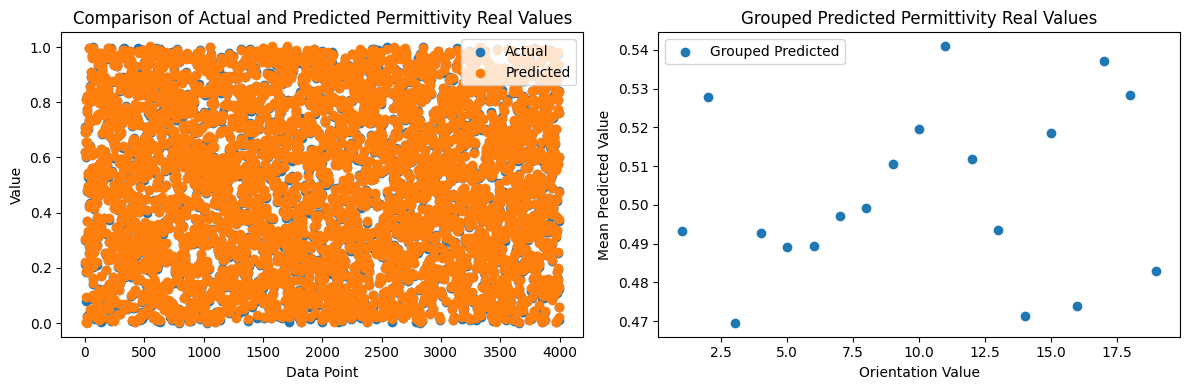

In [19]:
y_pred = model.predict(X_val)
# Create a DataFrame with "orientation_value" and "y_pred" columns
df_predicted = pd.DataFrame({'orientation_value': collapse_orientation_int['orientation'][split_point:], 'y_pred': y_pred[:, 0]})

# Group the predicted values by "orientation_value" and calculate the mean
y_pred_grouped = df_predicted.groupby('orientation_value')['y_pred'].mean().reset_index()

# Plot the comparison of actual and predicted permittivity real values for all data points
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 0], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 0], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

# Plot the grouped predicted permittivity real values for each orientation category
plt.subplot(1, 2, 2)
plt.scatter(y_pred_grouped['orientation_value'], y_pred_grouped['y_pred'], label='Grouped Predicted')
plt.title('Grouped Predicted Permittivity Real Values')
plt.xlabel('Orientation Value')
plt.ylabel('Mean Predicted Value')
plt.legend()

plt.tight_layout()
plt.show()


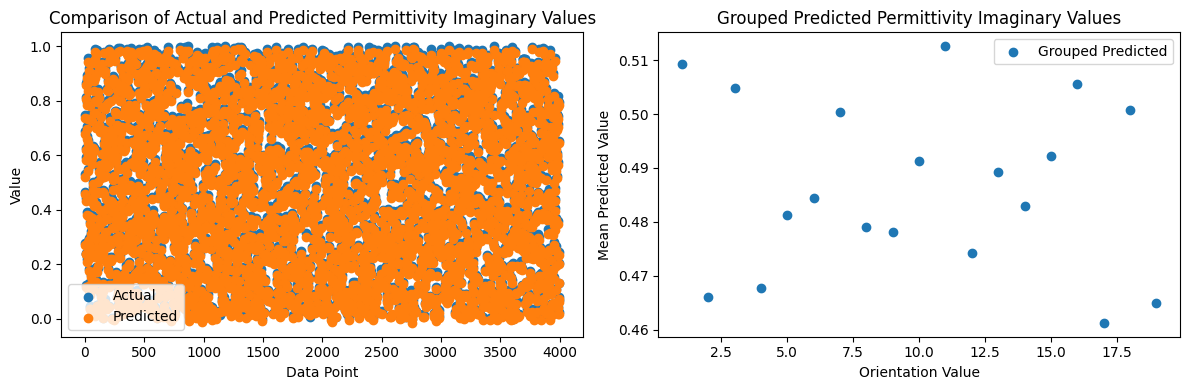

In [20]:
df_predicted = pd.DataFrame({'orientation_value': collapse_orientation_int['orientation'][split_point:], 'y_pred': y_pred[:, 1]})

# Group the predicted values by "orientation_value" and calculate the mean
y_pred_grouped = df_predicted.groupby('orientation_value')['y_pred'].mean().reset_index()

# Plot the comparison of actual and predicted permittivity real values for all data points
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 1], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 1], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

# Plot the grouped predicted permittivity real values for each orientation category
plt.subplot(1, 2, 2)
plt.scatter(y_pred_grouped['orientation_value'], y_pred_grouped['y_pred'], label='Grouped Predicted')
plt.title('Grouped Predicted Permittivity Imaginary Values')
plt.xlabel('Orientation Value')
plt.ylabel('Mean Predicted Value')
plt.legend()

plt.tight_layout()
plt.show()